In [1]:
# package
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import seasonal_plot
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from matplotlib import pyplot

from numpy import sqrt
from datetime import datetime, timedelta,date
from sklearn.metrics import mean_squared_error
#importing machine learning libraries
import pickle
import gc # to free some space from the memory
from sklearn.model_selection import KFold

import statsmodels.api as sm
import itertools

import warnings
warnings.filterwarnings("ignore")

#importing regressors
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor 
from xgboost import plot_importance
from lightgbm import plot_importance
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
import re

from sklearn.feature_selection import SelectFromModel

In [2]:
df1 = pd.read_csv(r"D:\HSC\WinterPressuresSource.csv")
# removing 1st row(blank row) and droping the missing DOI from the data set found 61 missing.
df1 = df1.drop(index=0)
df1 = df1.dropna(subset=["Date of Incident"])

In [3]:
df = df1.copy()
df = df.fillna('') # Replace NaN with blank

In [4]:
import re
import pandas as pd

def detect_date_format(date_str):
    formats = [
        r'\d{2}/\d{2}/\d{4}',  # dd/mm/yyyy
        r'\d{4}/\d{2}/\d{2}',  # yyyy/mm/dd
        r'\d{4}-\d{2}-\d{2}',  # yyyy-mm-dd
        r'\d{2}-\d{2}-\d{4}'   # dd-mm-yyyy
    ]
    for format_str in formats:
        if re.match(format_str, date_str):
            return format_str
    return None

def convert_date_format(date_str):
    detected_format = detect_date_format(date_str)
    if detected_format:
        if '/' in detected_format:
            parts = date_str.split('/')
        else:
            parts = date_str.split('-')
        if len(parts[0]) == 4:  # yyyy/mm/dd format
            return f"{parts[2]}/{parts[1]}/{parts[0]}"
        else:  # dd/mm/yyyy or yyyy-mm-dd format
            return date_str
    else:
        return None

# Apply conversion to the "Arrival Date" column
df["Date of Incident"] = df["Date of Incident"].apply(convert_date_format)
df["Arrival Date"] = df["Arrival Date"].apply(convert_date_format)
df["Ambulance Arrival Date"] = df["Ambulance Arrival Date"].apply(convert_date_format)
df["Ambulance Handover Date"] = df["Ambulance Handover Date"].apply(convert_date_format)
df["Triage Date"] = df["Triage Date"].apply(convert_date_format)
df["First Clinician Date"] = df["First Clinician Date"].apply(convert_date_format)
df["Decision to Admit Date"] = df["Decision to Admit Date"].apply(convert_date_format)
df["Date to Ward"] = df["Date to Ward"].apply(convert_date_format)
df["Left Dept Date"] = df["Left Dept Date"].apply(convert_date_format)

In [6]:
df["Date of Incident"] = pd.to_datetime(df["Date of Incident"])
df["Date of Incident"] = pd.to_datetime(df["Date of Incident"], format="%Y-%d-%m %H:%M:%S")
# Assuming 'df' is your DataFrame
df['Time of Incident'] = pd.to_datetime(df['Time of Incident'], errors='coerce').dt.time

# Assuming 'df' is your DataFrame
df['Date of Incident'] = pd.to_datetime(df['Date of Incident'])
df['Time of Incident'] = pd.to_timedelta(df['Time of Incident'].astype(str))

# Combine 'Date of Incident' and 'Time of Incident' into a new column 'incident_date_time'
df['incident_date_time'] = df['Date of Incident'] + df['Time of Incident']

# Drop the 'Time of Incident' column
df.drop('Time of Incident', axis=1, inplace=True)

In [7]:
# Assuming 'df' is your DataFrame
df['Ambulance Arrival Date'] = pd.to_datetime(df['Ambulance Arrival Date'],format="%d/%m/%Y")
df['Ambulance Arrival Time'] = pd.to_datetime(df['Ambulance Arrival Time'], errors='coerce').dt.time

# Combine 'Ambulance Arrival Date' and 'Ambulance Arrival Time' into a new column 'Ambulance Arrival Date Time'
df['Ambulance_Arrival_Date_Time'] = df['Ambulance Arrival Date'] + pd.to_timedelta(df['Ambulance Arrival Time'].astype(str))

# Drop the 'Ambulance Arrival Date' and 'Ambulance Arrival Time' columns if needed
df.drop(['Ambulance Arrival Time'], axis=1, inplace=True)

In [8]:
# Assuming 'df' is your DataFrame
df['Ambulance Handover Date'] = pd.to_datetime(df['Ambulance Handover Date'])
df['Ambulance Handover Time'] = pd.to_datetime(df['Ambulance Handover Time'], errors='coerce').dt.time

# Combine 'Ambulance Arrival Date' and 'Ambulance Arrival Time' into a new column 'Ambulance Arrival Date Time'
df['Ambulance_Handover_Date_Time'] = df['Ambulance Handover Date'] + pd.to_timedelta(df['Ambulance Handover Time'].astype(str))

# Drop the 'Ambulance Arrival Date' and 'Ambulance Arrival Time' columns if needed
df.drop(['Ambulance Handover Time'], axis=1, inplace=True)

In [5]:
# Assuming 'df' is your DataFrame
df['Arrival Date'] = pd.to_datetime(df['Arrival Date'],format="%d/%m/%Y")
df['Arrival Time'] = pd.to_datetime(df['Arrival Time'], errors='coerce').dt.time

# Combine 'Arrival Date' and 'Arrival Time' into a new column 'Arrival Date Time'
df['Arrival_Date_Time'] = df['Arrival Date'] + pd.to_timedelta(df['Arrival Time'].astype(str))

# Drop the 'Arrival Date' column if needed
df.drop('Arrival Time', axis=1, inplace=True)

In [9]:
df['Triage Date'] = pd.to_datetime(df['Triage Date'],format="%d/%m/%Y")

df['Triage Time'] = pd.to_datetime(df['Triage Time'], errors='coerce').dt.time

# Combine 'Triage Date' and 'Triage Time' into a new column 'Triage Date Time'
df['Triage_Date_Time'] = df['Triage Date'] + pd.to_timedelta(df['Triage Time'].astype(str))

# Drop the 'Triage Date' column if needed
df.drop('Triage Time', axis=1, inplace=True)

In [10]:
df['First Clinician Date'] = pd.to_datetime(df['First Clinician Date'],format="%d/%m/%Y")

df['First Clinician Time'] = pd.to_datetime(df['First Clinician Time'], errors='coerce').dt.time

# Combine 'Triage Date' and 'Triage Time' into a new column 'Triage Date Time'
df['First_Clinician_Date_Time'] = df['First Clinician Date'] + pd.to_timedelta(df['First Clinician Time'].astype(str))

# Drop the 'Triage Date' column if needed
df.drop('First Clinician Time', axis=1, inplace=True)

In [10]:
df['Decision to Admit Date'] = pd.to_datetime(df['Decision to Admit Date'],format="%d/%m/%Y")
df['Decision to Admit Time'] = pd.to_datetime(df['Decision to Admit Time'], errors='coerce').dt.time

# Combine 'Triage Date' and 'Triage Time' into a new column 'Triage Date Time'
df['Decision_to_Admit_date_Time'] = df['Decision to Admit Date'] + pd.to_timedelta(df['Decision to Admit Time'].astype(str))

# Drop the 'Triage Date' column if needed
df.drop('Decision to Admit Time', axis=1, inplace=True)

In [11]:
df['Date to Ward'] = pd.to_datetime(df['Date to Ward'],format="%d/%m/%Y")
df['Time to Ward'] = pd.to_datetime(df['Time to Ward'], errors='coerce').dt.time

# Combine 'Triage Date' and 'Triage Time' into a new column 'Triage Date Time'
df['Date_to_Ward_DATE_Time'] = df['Date to Ward'] + pd.to_timedelta(df['Time to Ward'].astype(str))

# Drop the 'Triage Date' column if needed
df.drop('Time to Ward', axis=1, inplace=True)

In [12]:
# Convert 'Left Dept Date' to datetime format, handling incorrect date formats
df['Left Dept Date'] = pd.to_datetime(df['Left Dept Date'],format="%d/%m/%Y")
# Convert 'Left Dept Time' to datetime.time format
df['Left Dept Time'] = pd.to_datetime(df['Left Dept Time'], errors='coerce').dt.time
# Combine 'Left Dept Date' and 'Left Dept Time' into a new column 'Left_Dept_Date_Time'
df['Left_Dept_Date_Time'] = df['Left Dept Date'] + pd.to_timedelta(df['Left Dept Time'].astype(str))

# Drop the 'Left Dept Time' column
df.drop('Left Dept Time', axis=1, inplace=True)

In [48]:
# Define the age ranges and corresponding labels
age_bins = [0, 18, 45, 55, 65, 75, 85, float('inf')]
age_labels = ['<18', '18-44', '45-54', '55-64', '65-74', '75-84', '85+']


# Convert the 'Age' column to numeric, replacing empty strings with NaN
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Drop rows with missing 'Age' values
df.dropna(subset=['Age'], inplace=True)

# Convert 'Age' into categorical classes
df['Age_Category'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)

# 46 missing in Age were dropped
df.dropna(subset="Age_Category",inplace=True)

# # View the updated DataFrame with the 'Age_Category' column
# print(df[['Age', 'Age_Category']])

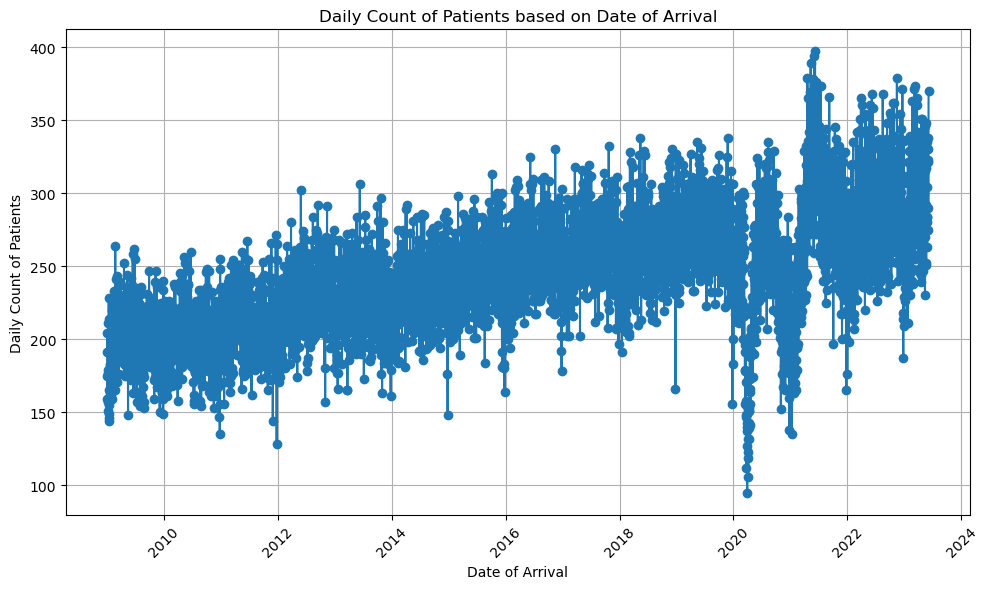

In [49]:
# Group by 'Date of Arrival' and calculate the daily count of patients
daily_patient_count = df.groupby('Arrival Date').size()

# Plot the daily count of patients
plt.figure(figsize=(10, 6))
plt.plot(daily_patient_count.index, daily_patient_count.values, marker='o', linestyle='-')
plt.xlabel('Date of Arrival')
plt.ylabel('Daily Count of Patients')
plt.title('Daily Count of Patients based on Date of Arrival')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Slicing the winter data

In [37]:
# Filter the DataFrame to keep only winter months (October to March)
df_winter = df[df["Arrival Date"].dt.month.isin([10, 11, 12, 1, 2, 3])]
# Use a conditional filter to remove rows where 'Triage Code' is an empty string
df_winter = df_winter[df_winter['Triage Code'] != '']

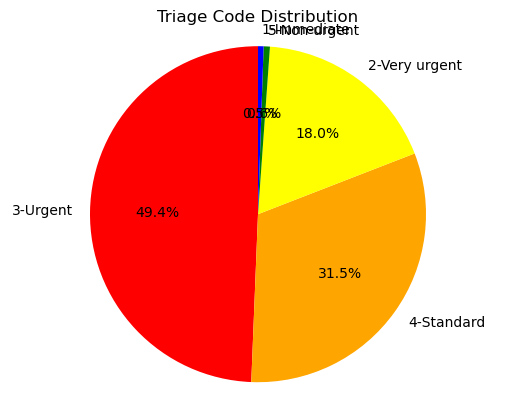

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named "df_winter" containing the Triage Code data

# Define a dictionary to map the numeric values to their corresponding labels
triage_labels = {
    1: '1-Immediate',
    2: '2-Very urgent',
    3: '3-Urgent',
    4: '4-Standard',
    5: '5-Non-urgent'
}

# Replace the numeric values with the corresponding labels
df_winter['Triage Code'] = df_winter['Triage Code'].map(triage_labels)

# Calculate the value counts for each Triage Code label
triage_counts = df_winter['Triage Code'].value_counts()

# Create a pie chart
fig, ax = plt.subplots()
ax.pie(triage_counts, labels=triage_counts.index, autopct='%1.1f%%', startangle=90, colors=['red', 'orange', 'yellow', 'green', 'blue'])

# Set title
ax.set_title('Triage Code Distribution')

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Display the plot
plt.show()

In [39]:
df_winter["Triage Code"].unique()

array(['4-Standard', '3-Urgent', '1-Immediate', '2-Very urgent',
       '5-Non-urgent'], dtype=object)

### Data preparation

In [40]:
import pandas as pd

# Assuming df_winter is your DataFrame
# Group the data by 'Arrival Date' and 'Triage Code', then count the number of occurrences
triage_counts = df_winter.groupby(['Arrival Date', 'Triage Code']).size().reset_index(name='Count')

# Pivot the table to have 'Arrival Date' as the index, 'Triage Code' as columns, and 'Count' as values
triage_pivot = triage_counts.pivot_table(index='Arrival Date', columns='Triage Code', values='Count', fill_value=0)

# Now triage_pivot contains the count of people for each Triage Code on each Arrival Date


In [41]:
triage_pivot

Triage Code,1-Immediate,2-Very urgent,3-Urgent,4-Standard,5-Non-urgent
Arrival Date,,,,,
2009-01-01,1,4,107,73,0
2009-01-02,1,9,143,41,5
2009-01-03,3,4,115,45,0
2009-01-04,0,13,84,58,0
2009-01-05,1,3,99,71,2
...,...,...,...,...,...
2023-03-27,3,99,131,105,2
2023-03-28,1,89,117,104,5
2023-03-29,1,73,131,100,4


In [42]:
winter_daily_patient_count = df_winter.groupby("Arrival Date").size()
# Group by 'Arrival Date' and calculate the daily count of patients
winter_daily_patient_count = df_winter.groupby("Arrival Date").size().reset_index(name='Patient Count')

winter_daily_patient_count.set_index("Arrival Date",inplace=True)

In [43]:
winter_daily_patient_count

,Patient Count
Arrival Date,
2009-01-01,185
2009-01-02,199
2009-01-03,167
2009-01-04,155
2009-01-05,176
...,...
2023-03-27,340
2023-03-28,316
2023-03-29,309


In [44]:
import pandas as pd

# Merge the triage count data with winter_daily_patient_count based on 'Arrival Date'
merged_data = winter_daily_patient_count.merge(triage_pivot, left_index=True, right_index=True, how='left')

In [45]:
merged_data

,Patient Count,1-Immediate,2-Very urgent,3-Urgent,4-Standard,5-Non-urgent
Arrival Date,,,,,,
2009-01-01,185,1,4,107,73,0
2009-01-02,199,1,9,143,41,5
2009-01-03,167,3,4,115,45,0
2009-01-04,155,0,13,84,58,0
2009-01-05,176,1,3,99,71,2
...,...,...,...,...,...,...
2023-03-27,340,3,99,131,105,2
2023-03-28,316,1,89,117,104,5
2023-03-29,309,1,73,131,100,4


In [47]:
import pandas as pd

# Assuming you have a DataFrame named 'df' with your data
# You can replace 'df' with your actual DataFrame

# Calculate proportions for each triage category
triage_categories = ['1-Immediate', '2-Very urgent', '3-Urgent', '4-Standard', '5-Non-urgent']

for category in triage_categories:
    merged_data[f'Proportion_{category}'] = merged_data[category] / merged_data['Patient Count']

# Display the DataFrame with proportions
merged_data


,Patient Count,1-Immediate,2-Very urgent,3-Urgent,4-Standard,5-Non-urgent,Proportion_1-Immediate,Proportion_2-Very urgent,Proportion_3-Urgent,Proportion_4-Standard,Proportion_5-Non-urgent
Arrival Date,,,,,,,,,,,
2009-01-01,185,1,4,107,73,0,0.005405,0.021622,0.578378,0.394595,0.000000
2009-01-02,199,1,9,143,41,5,0.005025,0.045226,0.718593,0.206030,0.025126
2009-01-03,167,3,4,115,45,0,0.017964,0.023952,0.688623,0.269461,0.000000
2009-01-04,155,0,13,84,58,0,0.000000,0.083871,0.541935,0.374194,0.000000
2009-01-05,176,1,3,99,71,2,0.005682,0.017045,0.562500,0.403409,0.011364
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,340,3,99,131,105,2,0.008824,0.291176,0.385294,0.308824,0.005882
2023-03-28,316,1,89,117,104,5,0.003165,0.281646,0.370253,0.329114,0.015823
2023-03-29,309,1,73,131,100,4,0.003236,0.236246,0.423948,0.323625,0.012945


In [52]:
merged_data = merged_data[['Patient Count','Proportion_1-Immediate','Proportion_2-Very urgent', 'Proportion_3-Urgent','Proportion_4-Standard', 'Proportion_5-Non-urgent']]

In [53]:
merged_data

,Patient Count,Proportion_1-Immediate,Proportion_2-Very urgent,Proportion_3-Urgent,Proportion_4-Standard,Proportion_5-Non-urgent
Arrival Date,,,,,,
2009-01-01,185,0.005405,0.021622,0.578378,0.394595,0.000000
2009-01-02,199,0.005025,0.045226,0.718593,0.206030,0.025126
2009-01-03,167,0.017964,0.023952,0.688623,0.269461,0.000000
2009-01-04,155,0.000000,0.083871,0.541935,0.374194,0.000000
2009-01-05,176,0.005682,0.017045,0.562500,0.403409,0.011364
...,...,...,...,...,...,...
2023-03-27,340,0.008824,0.291176,0.385294,0.308824,0.005882
2023-03-28,316,0.003165,0.281646,0.370253,0.329114,0.015823
2023-03-29,309,0.003236,0.236246,0.423948,0.323625,0.012945


In [54]:
# Create a new column 'Day of Week' containing the day of the week for each Arrival Date
merged_data.index.name = "Arrival Date"

merged_data["Day_of_Week"] = merged_data.index.day_name()

# Create a new column 'Month' containing the name of the month for each Arrival Date
merged_data["Month"] = merged_data.index.strftime('%B')

# Create a new column 'COVID Status' indicating whether the year is within the COVID-19 pandemic period
merged_data["COVID_Status"] = merged_data.index.map(lambda x: 'Yes' if 2019 <= x.year <= 2021 else 'No')

def get_season(arrival_date):
    year = arrival_date.year
    if arrival_date.month >= 10:
        season = f"{year} to {year + 1}"
    else:
        season = f"{year - 1} to {year}"
    return season

# Apply the get_season function to the "Arrival Date" column
merged_data["Season"] = merged_data.index.map(get_season)

# Create a new column "Is Weekend" indicating whether the date is a weekend
merged_data["Is Weekend"] = merged_data.index.map(lambda x: x.weekday() >= 5)

In [55]:
merged_data

,Patient Count,Proportion_1-Immediate,Proportion_2-Very urgent,Proportion_3-Urgent,Proportion_4-Standard,Proportion_5-Non-urgent,Day_of_Week,Month,COVID_Status,Season,Is Weekend
Arrival Date,,,,,,,,,,,
2009-01-01,185,0.005405,0.021622,0.578378,0.394595,0.000000,Thursday,January,No,2008 to 2009,False
2009-01-02,199,0.005025,0.045226,0.718593,0.206030,0.025126,Friday,January,No,2008 to 2009,False
2009-01-03,167,0.017964,0.023952,0.688623,0.269461,0.000000,Saturday,January,No,2008 to 2009,True
2009-01-04,155,0.000000,0.083871,0.541935,0.374194,0.000000,Sunday,January,No,2008 to 2009,True
2009-01-05,176,0.005682,0.017045,0.562500,0.403409,0.011364,Monday,January,No,2008 to 2009,False
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,340,0.008824,0.291176,0.385294,0.308824,0.005882,Monday,March,No,2022 to 2023,False
2023-03-28,316,0.003165,0.281646,0.370253,0.329114,0.015823,Tuesday,March,No,2022 to 2023,False
2023-03-29,309,0.003236,0.236246,0.423948,0.323625,0.012945,Wednesday,March,No,2022 to 2023,False


In [56]:
from sklearn.preprocessing import LabelEncoder
# Perform label encoding for 'Day of Week', 'Month', and 'COVID Status'
# You can also use one-hot encoding if you prefer

# Define custom mappings for day of the week and month
day_mapping = {
    'Sunday': 0,
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6
}

month_mapping = {
    'January': 0,
    'February': 1,
    'March': 2,
    'April': 3,
    'May': 4,
    'June': 5,
    'July': 6,
    'August': 7,
    'September': 8,
    'October': 9,
    'November': 10,
    'December': 11
}

weekend_mapping = {
    True: 0,
    False: 1
    
}

# Apply the custom mappings to 'Day of Week' and 'Month'
merged_data['Day_of_Week_Encoded'] = merged_data['Day_of_Week'].map(day_mapping)
merged_data['Month_Encoded'] = merged_data['Month'].map(month_mapping)
merged_data['Is_Weekend_Encoded'] = merged_data["Is Weekend"].map(weekend_mapping)

label_encodings = {}

for column in ['COVID_Status']:
    le = LabelEncoder()
    merged_data[column + '_Encoded'] = le.fit_transform(merged_data[column])
    label_encodings[column] = le.classes_

# Print the label encodings for reference
for column, classes in label_encodings.items():
    print(column, ":", classes)
    

COVID_Status : ['No' 'Yes']


In [57]:
# Sample data for the "Season" column
seasons = ['2008 to 2009', '2009 to 2010', '2010 to 2011', '2011 to 2012',
           '2012 to 2013', '2013 to 2014', '2014 to 2015', '2015 to 2016',
           '2016 to 2017', '2017 to 2018', '2018 to 2019', '2019 to 2020',
           '2020 to 2021', '2021 to 2022', '2022 to 2023','2023 to 2024']
# Create a mapping of season labels to numerical values
season_to_num = {season: i for i, season in enumerate(seasons)}


# Apply the mapping to the "Season" column and add a new "Season_Num" column
merged_data["Season_Num"] = merged_data["Season"].map(season_to_num)

In [58]:
merged_data

,Patient Count,Proportion_1-Immediate,Proportion_2-Very urgent,Proportion_3-Urgent,Proportion_4-Standard,Proportion_5-Non-urgent,Day_of_Week,Month,COVID_Status,Season,Is Weekend,Day_of_Week_Encoded,Month_Encoded,Is_Weekend_Encoded,COVID_Status_Encoded,Season_Num
Arrival Date,,,,,,,,,,,,,,,,
2009-01-01,185,0.005405,0.021622,0.578378,0.394595,0.000000,Thursday,January,No,2008 to 2009,False,4,0,1,0,0
2009-01-02,199,0.005025,0.045226,0.718593,0.206030,0.025126,Friday,January,No,2008 to 2009,False,5,0,1,0,0
2009-01-03,167,0.017964,0.023952,0.688623,0.269461,0.000000,Saturday,January,No,2008 to 2009,True,6,0,0,0,0
2009-01-04,155,0.000000,0.083871,0.541935,0.374194,0.000000,Sunday,January,No,2008 to 2009,True,0,0,0,0,0
2009-01-05,176,0.005682,0.017045,0.562500,0.403409,0.011364,Monday,January,No,2008 to 2009,False,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,340,0.008824,0.291176,0.385294,0.308824,0.005882,Monday,March,No,2022 to 2023,False,1,2,1,0,14
2023-03-28,316,0.003165,0.281646,0.370253,0.329114,0.015823,Tuesday,March,No,2022 to 2023,False,2,2,1,0,14
2023-03-29,309,0.003236,0.236246,0.423948,0.323625,0.012945,Wednesday,March,No,2022 to 2023,False,3,2,1,0,14


# Processed data for the model 

In [60]:
sea_df= merged_data[["Patient Count","COVID_Status_Encoded","Month_Encoded","Day_of_Week_Encoded","Season_Num","Is_Weekend_Encoded",'Proportion_1-Immediate','Proportion_2-Very urgent', 'Proportion_3-Urgent','Proportion_4-Standard', 'Proportion_5-Non-urgent']]

In [69]:
sea_df.columns

Index(['Patient Count', 'COVID_Status_Encoded', 'Month_Encoded',
       'Day_of_Week_Encoded', 'Season_Num', 'Is_Weekend_Encoded',
       'Proportion_1-Immediate', 'Proportion_2-Very urgent',
       'Proportion_3-Urgent', 'Proportion_4-Standard',
       'Proportion_5-Non-urgent'],
      dtype='object')

# XG Boost

Metrics for Proportion_1-Immediate:
Mean Squared Error (MSE): 1.6394442251071884e-05
Mean Absolute Error (MAE): 0.0032317558731190642
Min Forecasting Error: 9.982416866090044e-05
Max Forecasting Error: 0.016477083743960872
Mean Forecasting Error: 0.0032317558731190642
Standard Deviation: 0.0024474199072662623
R-squared (R2): -0.006455098198670628
Correlation: 0.04602440701787978

Metrics for Proportion_2-Very urgent:
Mean Squared Error (MSE): 0.0014719388022547257
Mean Absolute Error (MAE): 0.030235959362837083
Min Forecasting Error: 0.00037124966635071477
Max Forecasting Error: 0.11882950668048142
Mean Forecasting Error: 0.030235959362837083
Standard Deviation: 0.02369480394702632
R-squared (R2): -0.03641691022168736
Correlation: 0.23371183777111107

Metrics for Proportion_3-Urgent:
Mean Squared Error (MSE): 0.0022177612612295835
Mean Absolute Error (MAE): 0.0392740823132664
Min Forecasting Error: 0.00016265766497203238
Max Forecasting Error: 0.1175409488961599
Mean Forecasting Error:

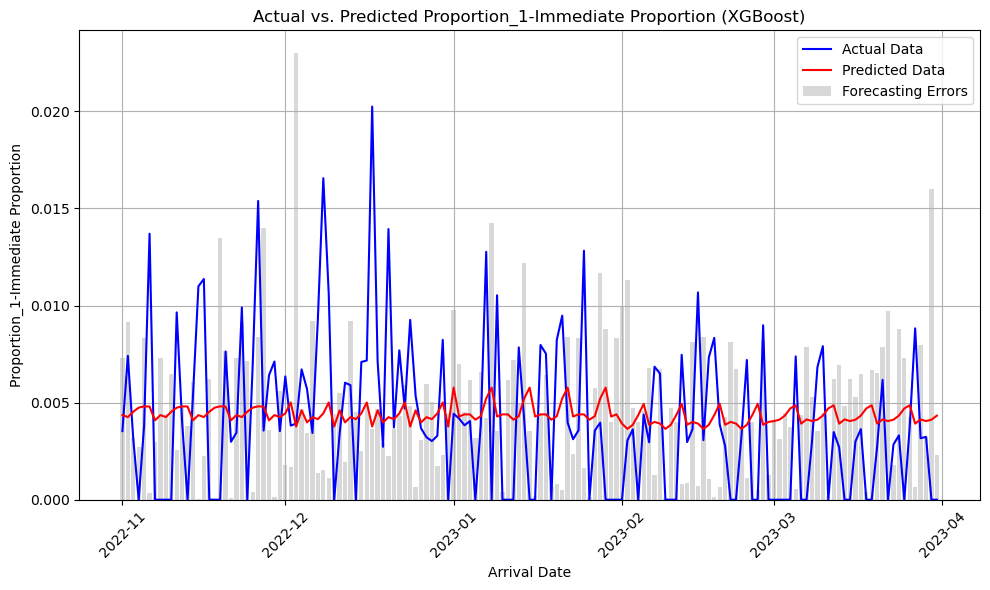

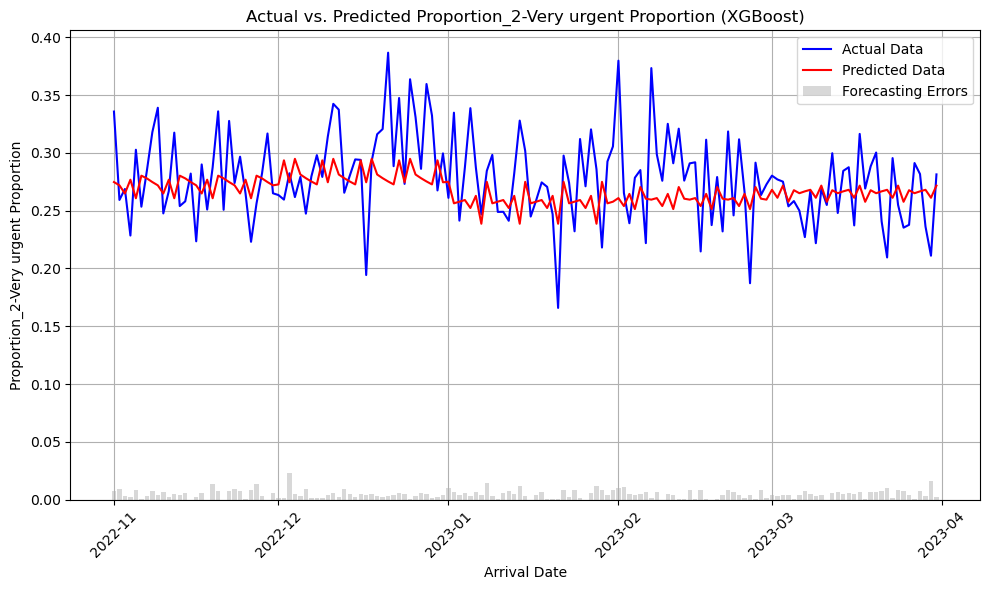

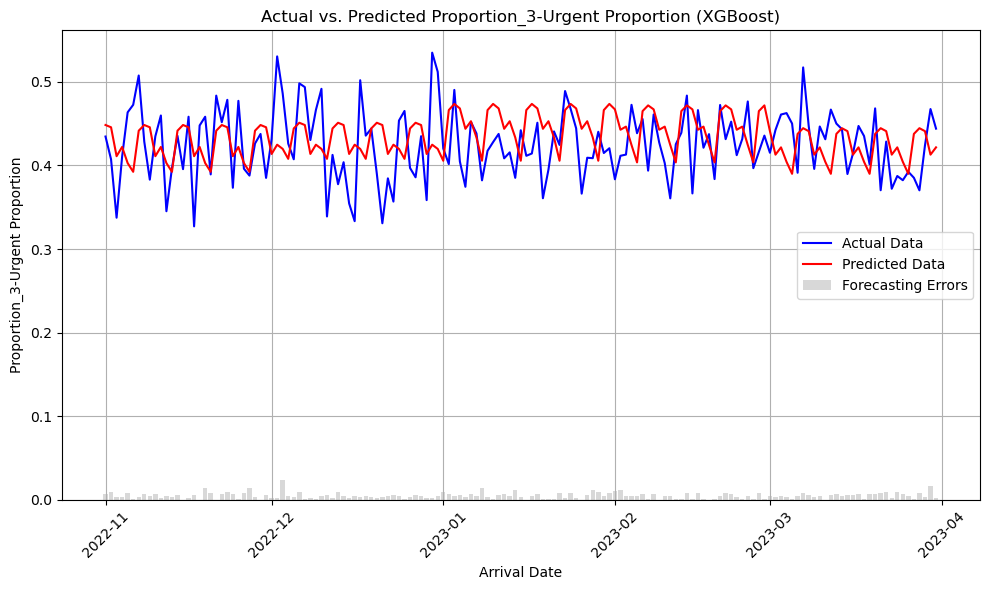

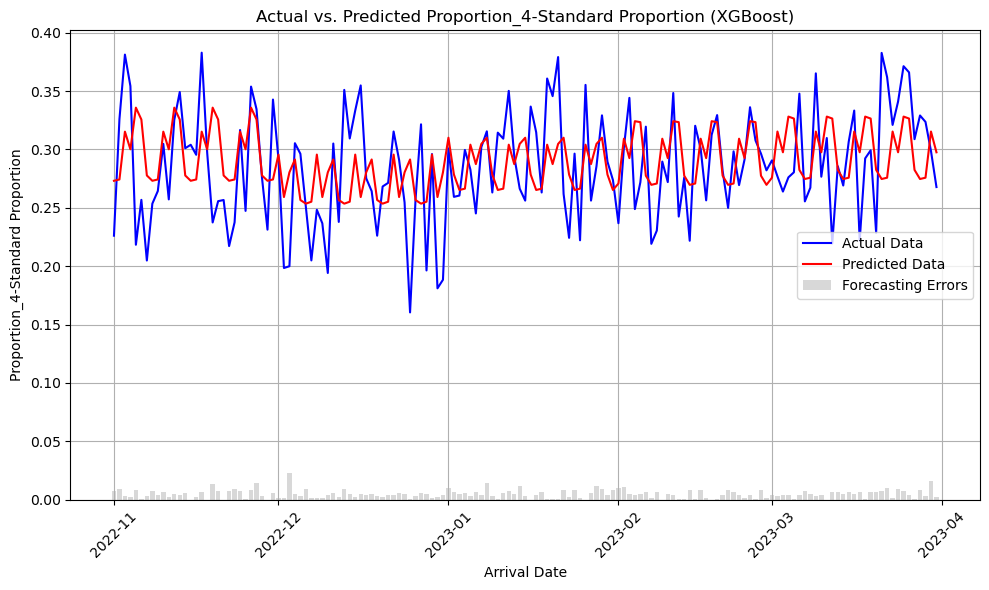

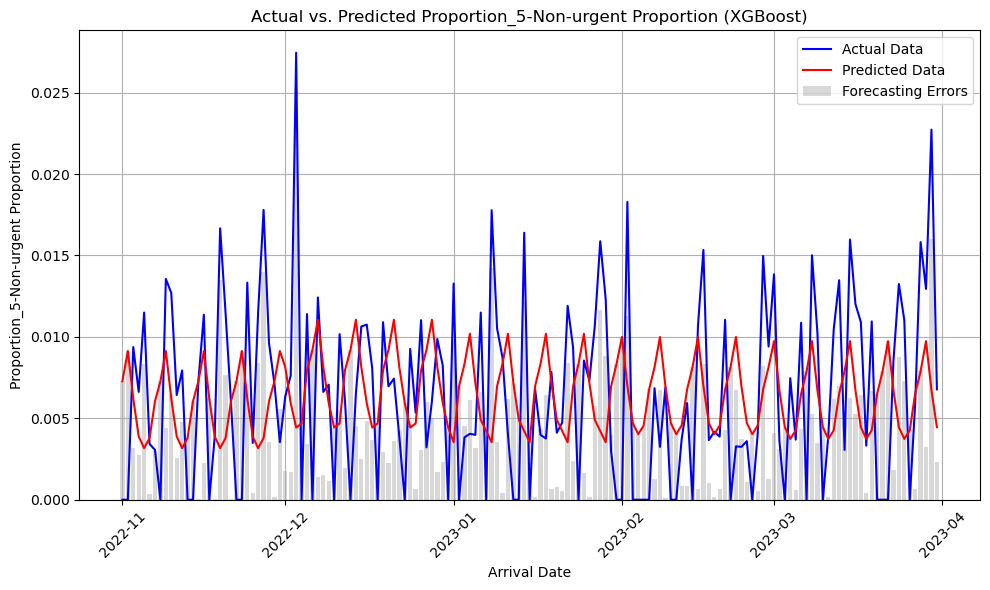

In [81]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load your data and set the index if not done already
# sea_df = pd.read_csv('your_data.csv', index_col='Arrival Date')

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Extract features and target variables
features = ["COVID_Status_Encoded", "Month_Encoded", "Day_of_Week_Encoded", "Season_Num", "Is_Weekend_Encoded"]
triage_proportions = ['Proportion_1-Immediate', 'Proportion_2-Very urgent', 'Proportion_3-Urgent',
                      'Proportion_4-Standard', 'Proportion_5-Non-urgent']

X_train = train_data[features]
y_train = train_data[triage_proportions]
X_test = test_data[features]
y_test = test_data[triage_proportions]

# Fit an XGBoost model for each triage proportion
models = {}
predictions_dfs = {}

for triage_label in triage_proportions:
    model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
    model.fit(X_train, y_train[triage_label])

    # Make predictions
    predictions = model.predict(X_test)

    # Create a DataFrame for predictions with the Arrival Date as the index
    prediction_dates = pd.date_range(start=test_start, end=test_end)
    predictions_df = pd.DataFrame({'Arrival Date': prediction_dates, f'Predicted_{triage_label}': predictions})
    predictions_df.set_index('Arrival Date', inplace=True)

    models[triage_label] = model
    predictions_dfs[triage_label] = predictions_df

# Calculate metrics for each triage proportion
metrics = {}

for triage_label in triage_proportions:
    mse = mean_squared_error(y_test[triage_label], predictions_dfs[triage_label][f'Predicted_{triage_label}'])
    mae = mean_absolute_error(y_test[triage_label], predictions_dfs[triage_label][f'Predicted_{triage_label}'])
    r2 = r2_score(y_test[triage_label], predictions_dfs[triage_label][f'Predicted_{triage_label}'])
    correlation = y_test[triage_label].corr(predictions_dfs[triage_label][f'Predicted_{triage_label}'])

    # Calculate statistics of forecasting error
    forecast_error = np.abs(y_test[triage_label] - predictions_dfs[triage_label][f'Predicted_{triage_label}'])
    min_error = forecast_error.min()
    max_error = forecast_error.max()
    mean_error = forecast_error.mean()
    std_deviation = forecast_error.std()

    metrics[triage_label] = {
        'MSE': mse,
        'MAE': mae,
        'Min Error': min_error,
        'Max Error': max_error,
        'Mean Error': mean_error,
        'Standard Deviation': std_deviation,
        'R2': r2,
        'Correlation': correlation
    }

# Print metrics for each triage proportion
for triage_label, metric_values in metrics.items():
    print(f"Metrics for {triage_label}:")
    print("Mean Squared Error (MSE):", metric_values['MSE'])
    print("Mean Absolute Error (MAE):", metric_values['MAE'])
    print("Min Forecasting Error:", metric_values['Min Error'])
    print("Max Forecasting Error:", metric_values['Max Error'])
    print("Mean Forecasting Error:", metric_values['Mean Error'])
    print("Standard Deviation:", metric_values['Standard Deviation'])
    print("R-squared (R2):", metric_values['R2'])
    print("Correlation:", metric_values['Correlation'])
    print()

# Visualize the results for each triage proportion
for triage_label in triage_proportions:
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test[triage_label], label='Actual Data', color='blue')
    plt.plot(predictions_dfs[triage_label].index, predictions_dfs[triage_label][f'Predicted_{triage_label}'],
             label='Predicted Data', color='red')
    plt.bar(predictions_dfs[triage_label].index, forecast_error, label='Forecasting Errors', alpha=0.3, color='gray')
    plt.xlabel('Arrival Date')
    plt.ylabel(f'{triage_label} Proportion')
    plt.title(f'Actual vs. Predicted {triage_label} Proportion (XGBoost)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [76]:
test_data

,Patient Count,COVID_Status_Encoded,Month_Encoded,Day_of_Week_Encoded,Season_Num,Is_Weekend_Encoded,Proportion_1-Immediate,Proportion_2-Very urgent,Proportion_3-Urgent,Proportion_4-Standard,Proportion_5-Non-urgent
Arrival Date,,,,,,,,,,,
2022-11-01,283,0,10,2,14,1,0.003534,0.335689,0.434629,0.226148,0.000000
2022-11-02,270,0,10,3,14,1,0.007407,0.259259,0.407407,0.325926,0.000000
2022-11-03,320,0,10,4,14,1,0.003125,0.268750,0.337500,0.381250,0.009375
2022-11-04,302,0,10,5,14,1,0.000000,0.228477,0.410596,0.354305,0.006623
2022-11-05,261,0,10,6,14,0,0.003831,0.302682,0.463602,0.218391,0.011494
...,...,...,...,...,...,...,...,...,...,...,...
2023-03-27,340,0,2,1,14,1,0.008824,0.291176,0.385294,0.308824,0.005882
2023-03-28,316,0,2,2,14,1,0.003165,0.281646,0.370253,0.329114,0.015823
2023-03-29,309,0,2,3,14,1,0.003236,0.236246,0.423948,0.323625,0.012945


In [ ]:
Regression

Metrics for Proportion_1-Immediate:
Mean Squared Error (MSE): 2.7296798618807594e-05
Mean Absolute Error (MAE): 0.00448097271248062
R-squared (R2): -0.675750947404455

Metrics for Proportion_2-Very urgent:
Mean Squared Error (MSE): 0.0015082736912637518
Mean Absolute Error (MAE): 0.030009833951647247
R-squared (R2): -0.06200091775127903

Metrics for Proportion_3-Urgent:
Mean Squared Error (MSE): 0.003308495322692286
Mean Absolute Error (MAE): 0.047586741255332195
R-squared (R2): -0.8789983636886882

Metrics for Proportion_4-Standard:
Mean Squared Error (MSE): 0.0033986417273388263
Mean Absolute Error (MAE): 0.04730114451061959
R-squared (R2): -0.5523187647654078

Metrics for Proportion_5-Non-urgent:
Mean Squared Error (MSE): 3.1710936873931177e-05
Mean Absolute Error (MAE): 0.004628857500669877
R-squared (R2): -0.024287509573319266



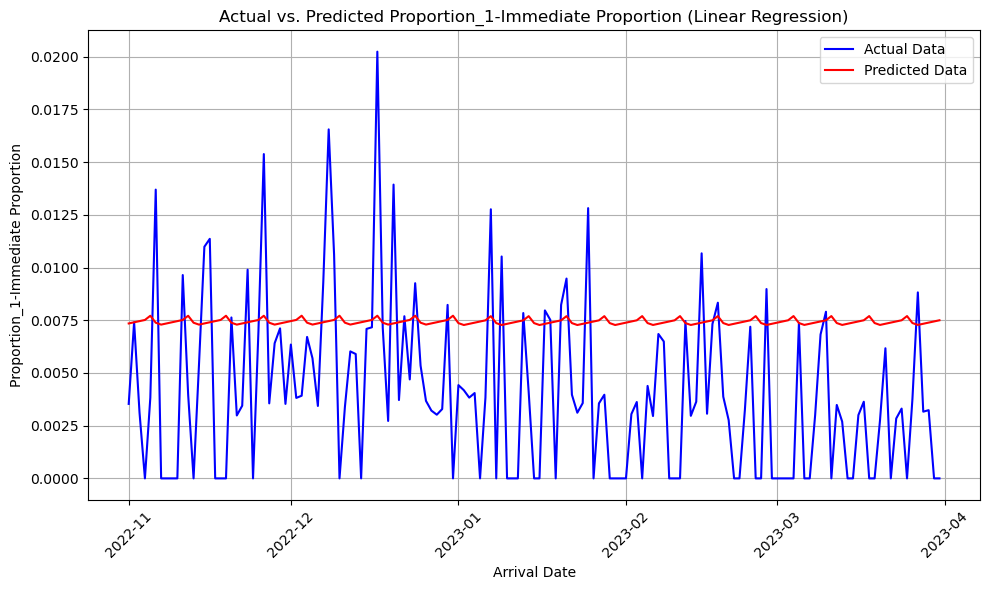

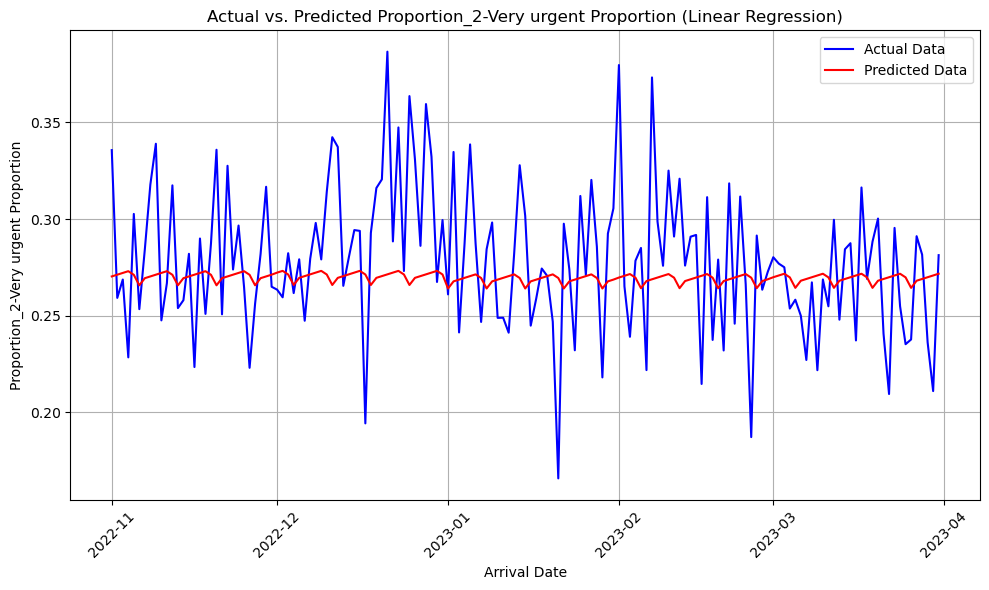

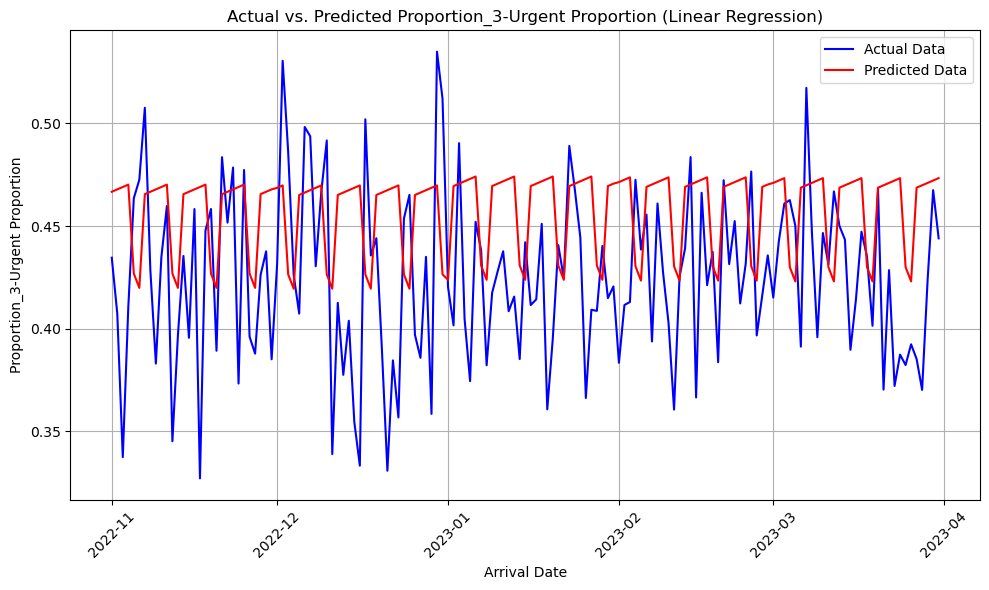

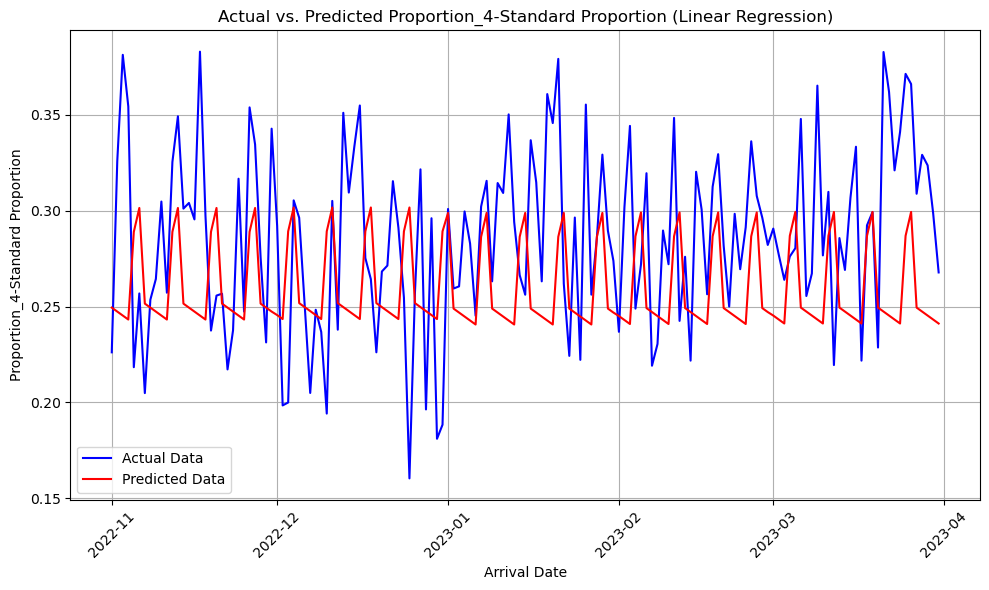

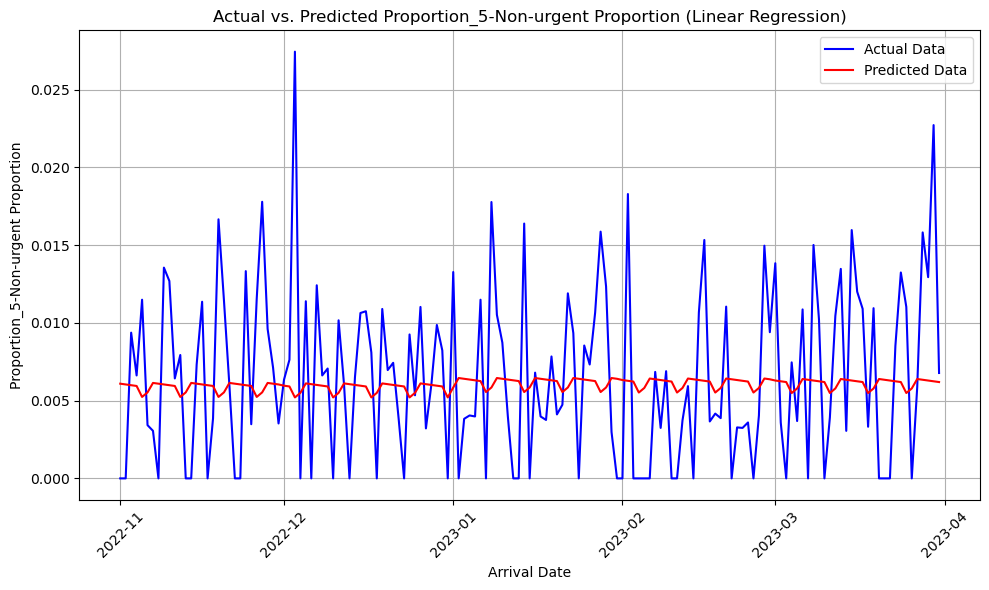

In [82]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load your data and set the index if not done already
# sea_df = pd.read_csv('your_data.csv', index_col='Arrival Date')

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Extract features and target variables
features = ["COVID_Status_Encoded", "Month_Encoded", "Day_of_Week_Encoded", "Season_Num", "Is_Weekend_Encoded"]
triage_proportions = ['Proportion_1-Immediate', 'Proportion_2-Very urgent', 'Proportion_3-Urgent',
                      'Proportion_4-Standard', 'Proportion_5-Non-urgent']

X_train = train_data[features]
X_test = test_data[features]

# Create separate models for each triage proportion
models = {}
predictions_dfs = {}

for triage_label in triage_proportions:
    model = LinearRegression()
    model.fit(X_train, train_data[triage_label])

    # Make predictions
    predictions = model.predict(X_test)

    # Create a DataFrame for predictions with the Arrival Date as the index
    prediction_dates = pd.date_range(start=test_start, end=test_end)
    predictions_df = pd.DataFrame({'Arrival Date': prediction_dates, f'Predicted_{triage_label}': predictions})
    predictions_df.set_index('Arrival Date', inplace=True)

    models[triage_label] = model
    predictions_dfs[triage_label] = predictions_df

# Calculate metrics for each triage proportion
metrics = {}

for triage_label in triage_proportions:
    mse = mean_squared_error(test_data[triage_label], predictions_dfs[triage_label][f'Predicted_{triage_label}'])
    mae = mean_absolute_error(test_data[triage_label], predictions_dfs[triage_label][f'Predicted_{triage_label}'])
    r2 = r2_score(test_data[triage_label], predictions_dfs[triage_label][f'Predicted_{triage_label}'])

    metrics[triage_label] = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

# Print metrics for each triage proportion
for triage_label, metric_values in metrics.items():
    print(f"Metrics for {triage_label}:")
    print("Mean Squared Error (MSE):", metric_values['MSE'])
    print("Mean Absolute Error (MAE):", metric_values['MAE'])
    print("R-squared (R2):", metric_values['R2'])
    print()

# Visualize the results for each triage proportion
for triage_label in triage_proportions:
    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, test_data[triage_label], label='Actual Data', color='blue')
    plt.plot(predictions_dfs[triage_label].index, predictions_dfs[triage_label][f'Predicted_{triage_label}'],
             label='Predicted Data', color='red')
    plt.xlabel('Arrival Date')
    plt.ylabel(f'{triage_label} Proportion')
    plt.title(f'Actual vs. Predicted {triage_label} Proportion (Linear Regression)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
Random Forest:

Metrics for Proportion_1-Immediate:
Mean Squared Error (MSE): 1.7600583335875115e-05
Mean Absolute Error (MAE): 0.003328840914990188
Min Forecasting Error: 6.934925717828975e-05
Max Forecasting Error: 0.017128856134517062
Mean Forecasting Error: 0.003328840914990188
Standard Deviation: 0.0025618087702284657
R-squared (R2): -0.08050012061275869
Correlation: 0.06366654050549989



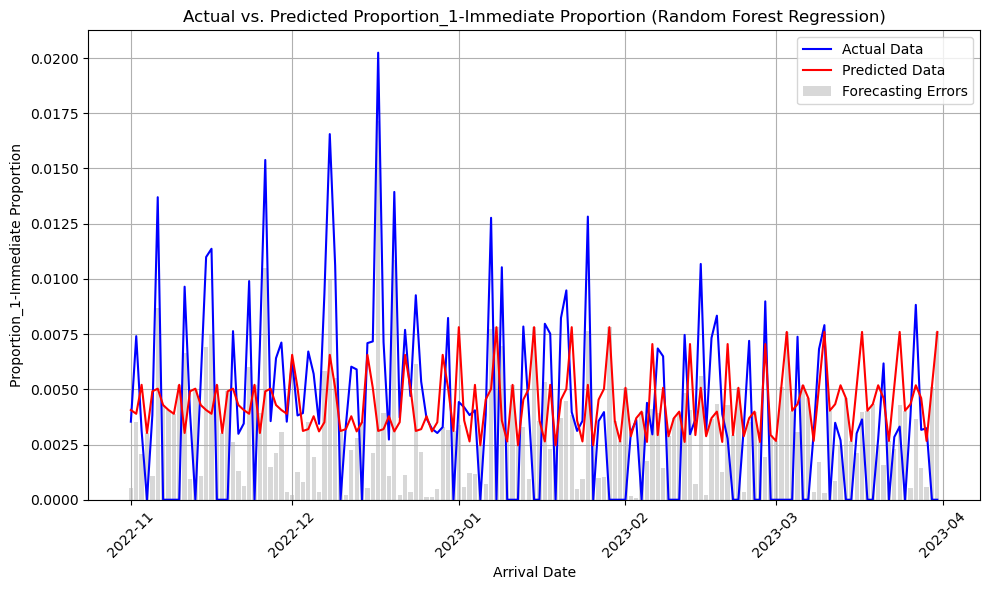

Metrics for Proportion_2-Very urgent:
Mean Squared Error (MSE): 0.001854762374216377
Mean Absolute Error (MAE): 0.0343580275975219
Min Forecasting Error: 1.4385325425525508e-05
Max Forecasting Error: 0.1213535967355292
Mean Forecasting Error: 0.0343580275975219
Standard Deviation: 0.026053475185659897
R-squared (R2): -0.30596943713704383
Correlation: 0.12635156287176913



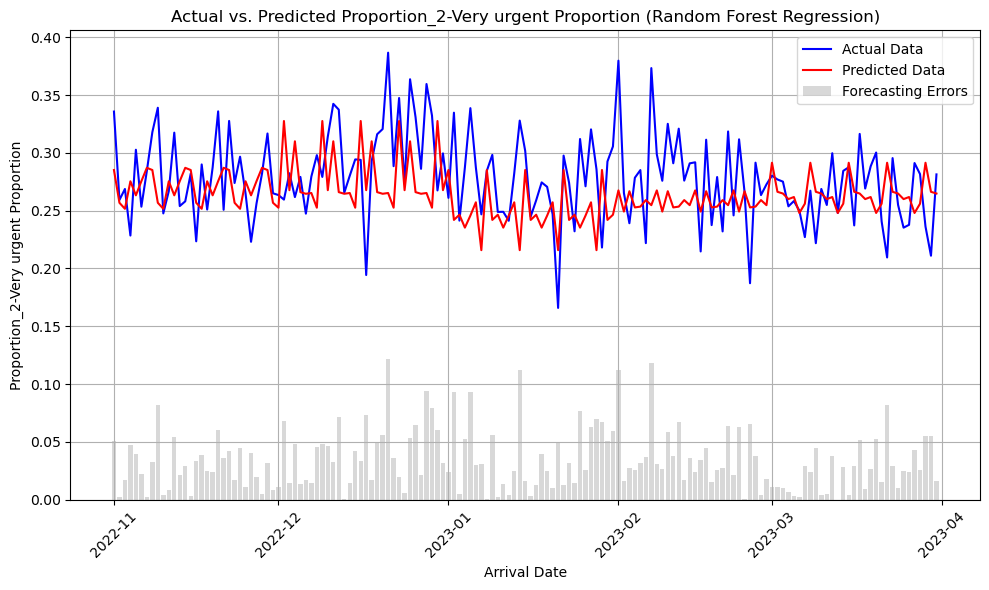

Metrics for Proportion_3-Urgent:
Mean Squared Error (MSE): 0.0023153966996541
Mean Absolute Error (MAE): 0.04025908983158772
Min Forecasting Error: 0.0004036869867399262
Max Forecasting Error: 0.11516930910606055
Mean Forecasting Error: 0.04025908983158772
Standard Deviation: 0.026443015489100802
R-squared (R2): -0.3149864774177533
Correlation: 0.1267619414141443



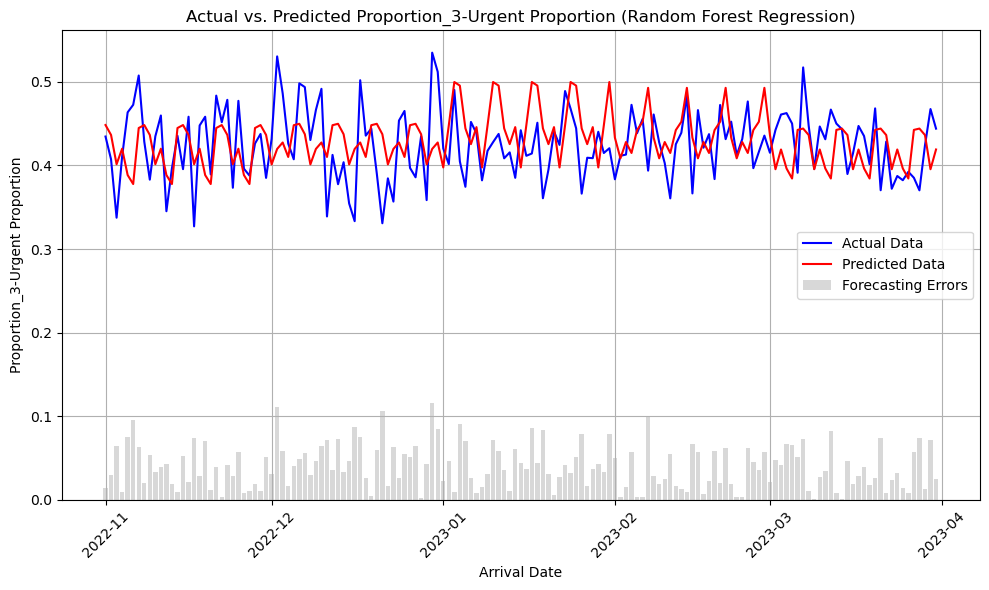

Metrics for Proportion_4-Standard:
Mean Squared Error (MSE): 0.0022608249963049767
Mean Absolute Error (MAE): 0.03949298455641689
Min Forecasting Error: 0.0009248688970591723
Max Forecasting Error: 0.12807688281134055
Mean Forecasting Error: 0.03949298455641689
Standard Deviation: 0.02656695996118371
R-squared (R2): -0.03262460334790651
Correlation: 0.29474459275024184



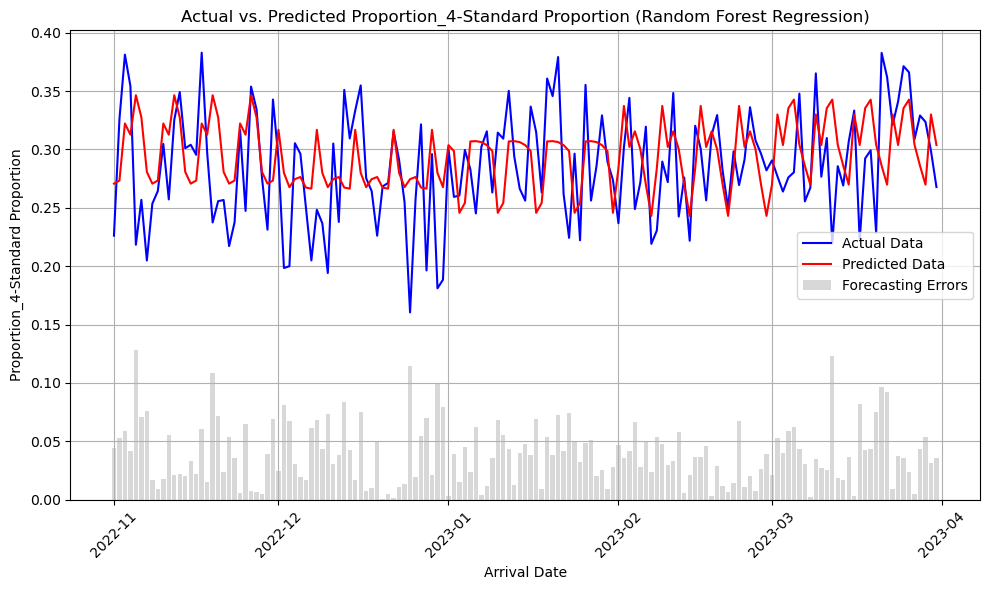

Metrics for Proportion_5-Non-urgent:
Mean Squared Error (MSE): 4.454046677120258e-05
Mean Absolute Error (MAE): 0.005475353522754869
Min Forecasting Error: 2.9031584755848886e-05
Max Forecasting Error: 0.02222013696248419
Mean Forecasting Error: 0.005475353522754869
Standard Deviation: 0.0038285824673376777
R-squared (R2): -0.4386911356697649
Correlation: -0.061588243803347924



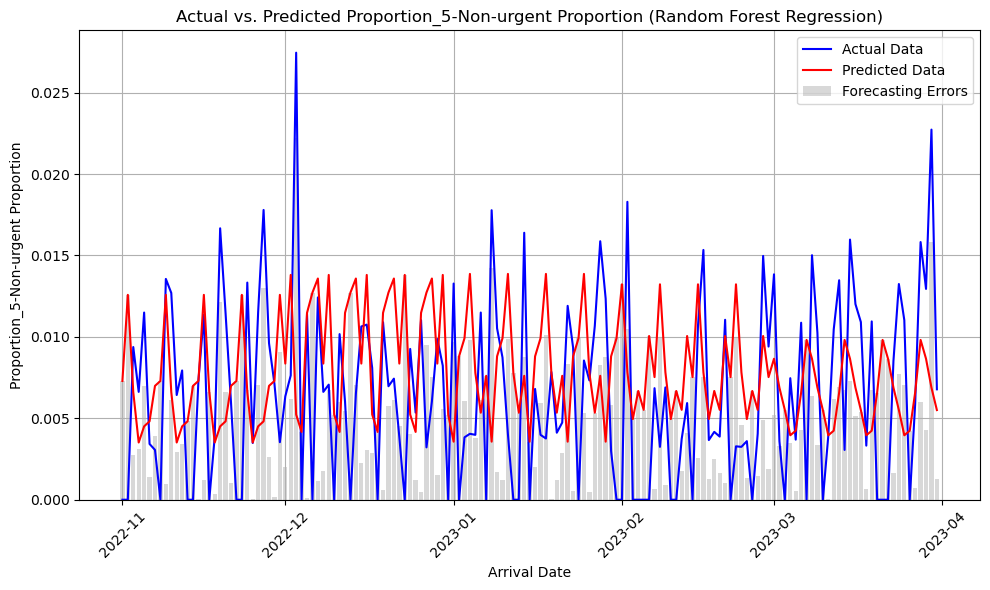

In [83]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load your data and set the index if not done already
# sea_df = pd.read_csv('your_data.csv', index_col='Arrival Date')

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Extract features and target variables
features = ["COVID_Status_Encoded", "Month_Encoded", "Day_of_Week_Encoded", "Season_Num", "Is_Weekend_Encoded"]
triage_proportions = ['Proportion_1-Immediate', 'Proportion_2-Very urgent', 'Proportion_3-Urgent',
                      'Proportion_4-Standard', 'Proportion_5-Non-urgent']

X_train = train_data[features]
X_test = test_data[features]

# Create separate models for each triage proportion
models = {}
predictions_dfs = {}
metrics = {}

for triage_label in triage_proportions:
    model = RandomForestRegressor(n_estimators=100, random_state=0)
    model.fit(X_train, train_data[triage_label])

    # Make predictions
    predictions = model.predict(X_test)

    # Create a DataFrame for predictions with the Arrival Date as the index
    prediction_dates = pd.date_range(start=test_start, end=test_end)
    predictions_df = pd.DataFrame({'Arrival Date': prediction_dates, f'Predicted_{triage_label}': predictions})
    predictions_df.set_index('Arrival Date', inplace=True)

    models[triage_label] = model
    predictions_dfs[triage_label] = predictions_df

    # Calculate metrics for each triage proportion
    mse = mean_squared_error(test_data[triage_label], predictions_df[f'Predicted_{triage_label}'])
    mae = mean_absolute_error(test_data[triage_label], predictions_df[f'Predicted_{triage_label}'])
    r2 = r2_score(test_data[triage_label], predictions_df[f'Predicted_{triage_label}'])
    correlation = test_data[triage_label].corr(predictions_df[f'Predicted_{triage_label}'])

    # Calculate statistics of forecasting error
    forecast_error = np.abs(test_data[triage_label] - predictions_df[f'Predicted_{triage_label}'])
    min_error = forecast_error.min()
    max_error = forecast_error.max()
    mean_error = forecast_error.mean()
    std_deviation = forecast_error.std()

    metrics[triage_label] = {
        'MSE': mse,
        'MAE': mae,
        'Min Error': min_error,
        'Max Error': max_error,
        'Mean Error': mean_error,
        'Standard Deviation': std_deviation,
        'R2': r2,
        'Correlation': correlation
    }

    # Print metrics for each triage proportion
    print(f"Metrics for {triage_label}:")
    print("Mean Squared Error (MSE):", mse)
    print("Mean Absolute Error (MAE):", mae)
    print("Min Forecasting Error:", min_error)
    print("Max Forecasting Error:", max_error)
    print("Mean Forecasting Error:", mean_error)
    print("Standard Deviation:", std_deviation)
    print("R-squared (R2):", r2)
    print("Correlation:", correlation)
    print()

    # Visualize the results for each triage proportion
    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, test_data[triage_label], label='Actual Data', color='blue')
    plt.plot(predictions_df.index, predictions_df[f'Predicted_{triage_label}'],
             label='Predicted Data', color='red')
    plt.bar(predictions_df.index, forecast_error, label='Forecasting Errors', alpha=0.3, color='gray')
    plt.xlabel('Arrival Date')
    plt.ylabel(f'{triage_label} Proportion')
    plt.title(f'Actual vs. Predicted {triage_label} Proportion (Random Forest Regression)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
ARIMA

Metrics for Proportion_1-Immediate:
Mean Squared Error (MSE): 1.6338051616989452e-05
Mean Absolute Error (MAE): 0.0031055790985505573
Min Forecasting Error: 1.5840294904546134e-05
Max Forecasting Error: 0.01635110569260448
Mean Forecasting Error: 0.0031055790985505573
Standard Deviation: 0.002595775981634958
R-squared (R2): -0.0029932761803455055


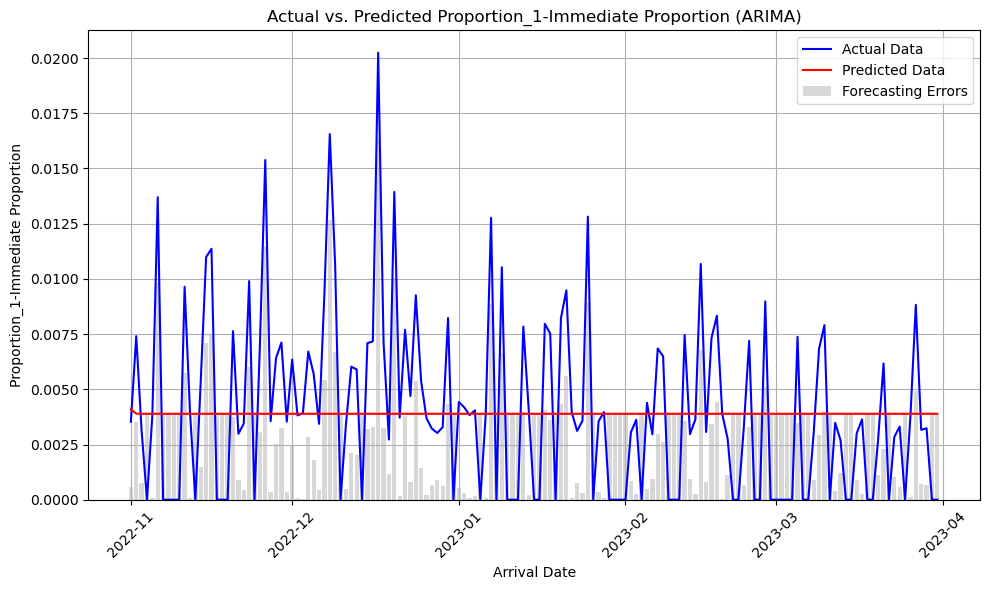

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load your data and set the index if not done already
# sea_df = pd.read_csv('your_data.csv', index_col='Arrival Date')

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Choose the triage proportion you want to forecast
triage_label = 'Proportion_1-Immediate'

# Extract the time series data
train_series = train_data[triage_label]
test_series = test_data[triage_label]

# Fit an ARIMA model
p, d, q = 1, 1, 1  # These are the ARIMA hyperparameters (you can tune them)
model = ARIMA(train_series, order=(p, d, q))
model_fit = model.fit()

# Make predictions
predictions = model_fit.forecast(steps=len(test_series))

# Create a DataFrame for predictions with the Arrival Date as the index
prediction_dates = pd.date_range(start=test_start, end=test_end)
predictions_df = pd.DataFrame({'Arrival Date': prediction_dates, f'Predicted_{triage_label}': predictions})
predictions_df.set_index('Arrival Date', inplace=True)

# Calculate metrics
mse = mean_squared_error(test_series, predictions_df[f'Predicted_{triage_label}'])
mae = mean_absolute_error(test_series, predictions_df[f'Predicted_{triage_label}'])
r2 = r2_score(test_series, predictions_df[f'Predicted_{triage_label}'])

# Calculate statistics of forecasting error
forecast_error = np.abs(test_series - predictions_df[f'Predicted_{triage_label}'])
min_error = forecast_error.min()
max_error = forecast_error.max()
mean_error = forecast_error.mean()
std_deviation = forecast_error.std()

print(f"Metrics for {triage_label}:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Min Forecasting Error:", min_error)
print("Max Forecasting Error:", max_error)
print("Mean Forecasting Error:", mean_error)
print("Standard Deviation:", std_deviation)
print("R-squared (R2):", r2)

# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(test_series.index, test_series, label='Actual Data', color='blue')
plt.plot(predictions_df.index, predictions_df[f'Predicted_{triage_label}'],
         label='Predicted Data', color='red')
plt.bar(predictions_df.index, forecast_error, label='Forecasting Errors', alpha=0.3, color='gray')
plt.xlabel('Arrival Date')
plt.ylabel(f'{triage_label} Proportion')
plt.title(f'Actual vs. Predicted {triage_label} Proportion (ARIMA)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
LSTM

5/5 [==============================] - 0s 1ms/step
Metrics for Proportion_1-Immediate:
Mean Squared Error (MSE): 2.9803215345141024e-05
Mean Absolute Error (MAE): 0.004297315845374065
R-squared (R2): -0.8296199143260821

Metrics for Proportion_2-Very urgent:
Mean Squared Error (MSE): 0.0030195289719254148
Mean Absolute Error (MAE): 0.04507019322737941
R-squared (R2): -1.1261012228321121

Metrics for Proportion_3-Urgent:
Mean Squared Error (MSE): 0.007462025325651926
Mean Absolute Error (MAE): 0.07544696947631262
R-squared (R2): -3.237918452093755

Metrics for Proportion_4-Standard:
Mean Squared Error (MSE): 0.07106515339573449
Mean Absolute Error (MAE): 0.25809739511200835
R-squared (R2): -31.45878206277107

Metrics for Proportion_5-Non-urgent:
Mean Squared Error (MSE): 7.027896889432788e-05
Mean Absolute Error (MAE): 0.006865952404283788
R-squared (R2): -1.2700644358233952



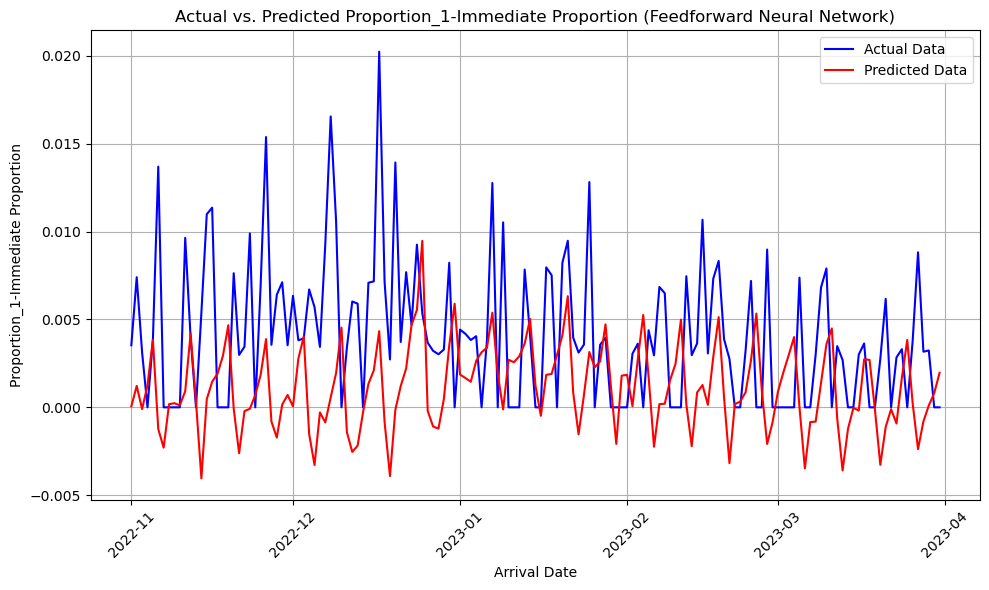

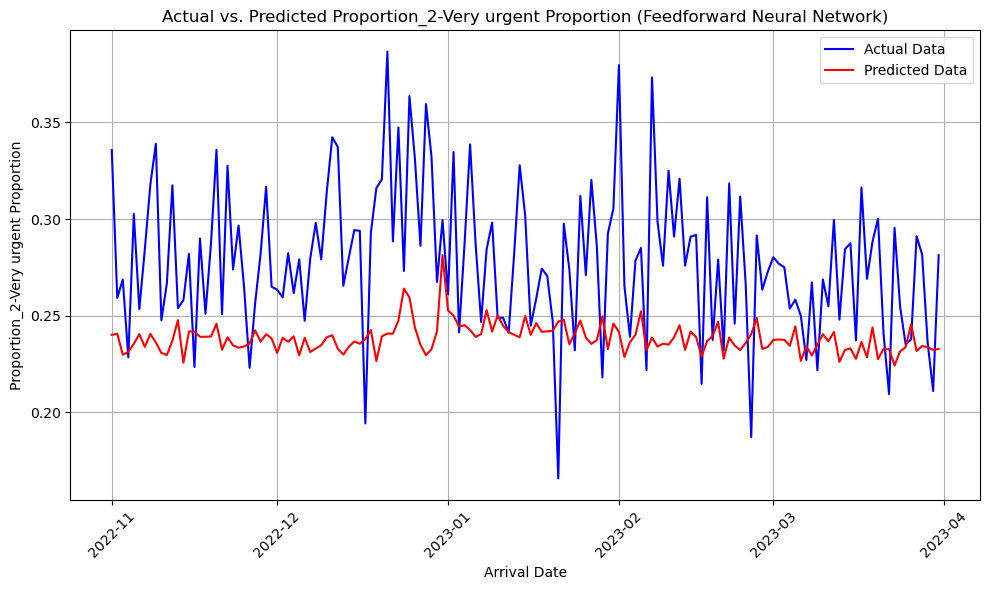

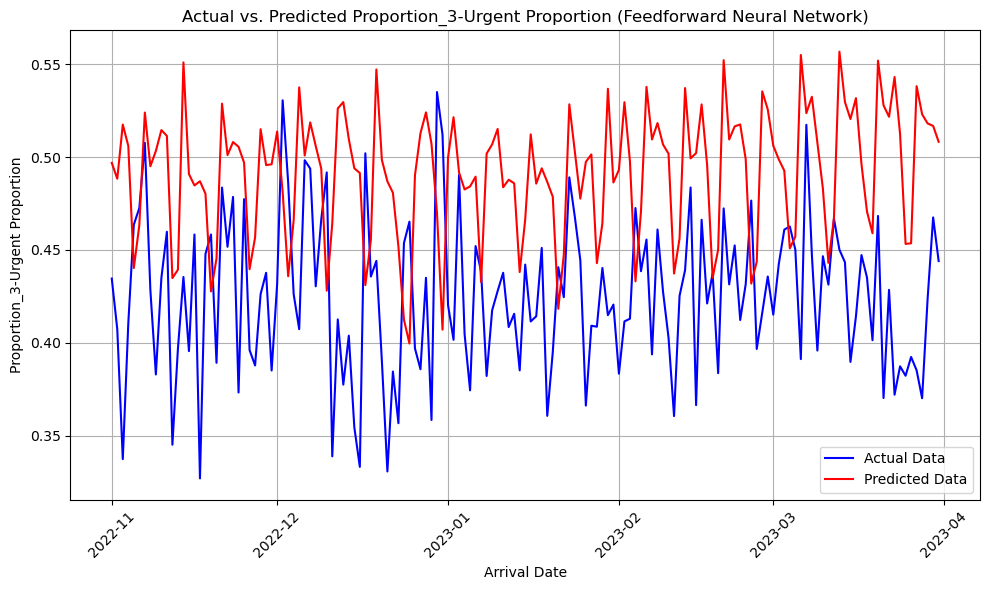

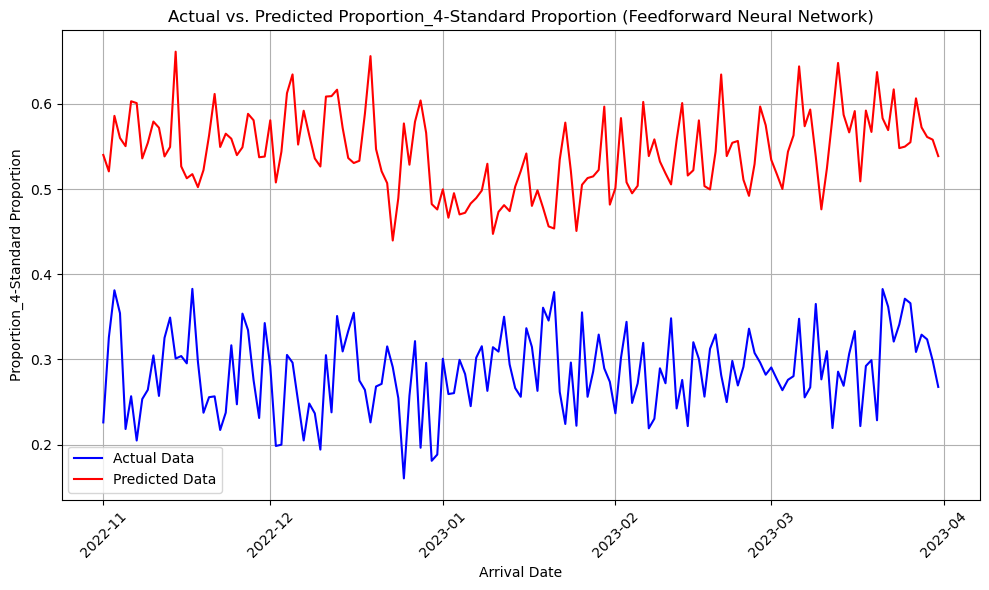

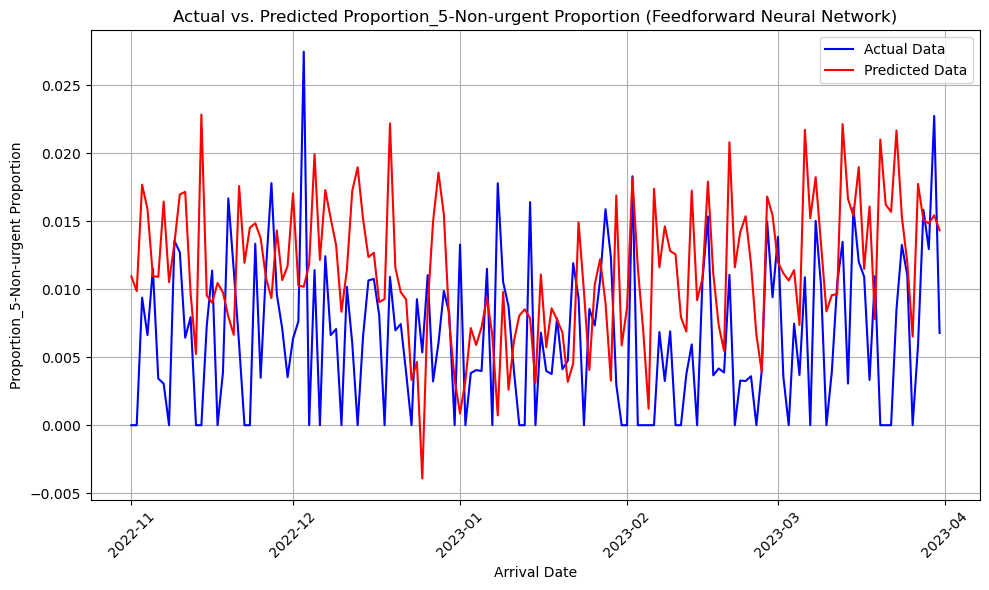

In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# Load your data and set the index if not done already
# sea_df = pd.read_csv('your_data.csv', index_col='Arrival Date')

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Extract features and target variables
triage_proportions = ['Proportion_1-Immediate', 'Proportion_2-Very urgent', 'Proportion_3-Urgent',
                      'Proportion_4-Standard', 'Proportion_5-Non-urgent']

X_train = train_data.drop(triage_proportions, axis=1)
y_train = train_data[triage_proportions]
X_test = test_data.drop(triage_proportions, axis=1)
y_test = test_data[triage_proportions]

# Create separate models for each triage proportion
models = {}
predictions_dfs = {}

for triage_label in triage_proportions:
    model = Sequential()
    model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    model.fit(X_train, y_train[triage_label], epochs=50, batch_size=32, verbose=0)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Create a DataFrame for predictions with the Arrival Date as the index
    prediction_dates = pd.date_range(start=test_start, end=test_end)
    predictions_df = pd.DataFrame({'Arrival Date': prediction_dates, f'Predicted_{triage_label}': predictions.flatten()})
    predictions_df.set_index('Arrival Date', inplace=True)
    
    models[triage_label] = model
    predictions_dfs[triage_label] = predictions_df

# Calculate metrics for each triage proportion
metrics = {}

for triage_label in triage_proportions:
    mse = mean_squared_error(y_test[triage_label], predictions_dfs[triage_label][f'Predicted_{triage_label}'])
    mae = mean_absolute_error(y_test[triage_label], predictions_dfs[triage_label][f'Predicted_{triage_label}'])
    r2 = r2_score(y_test[triage_label], predictions_dfs[triage_label][f'Predicted_{triage_label}'])

    metrics[triage_label] = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

# Print metrics for each triage proportion
for triage_label, metric_values in metrics.items():
    print(f"Metrics for {triage_label}:")
    print("Mean Squared Error (MSE):", metric_values['MSE'])
    print("Mean Absolute Error (MAE):", metric_values['MAE'])
    print("R-squared (R2):", metric_values['R2'])
    print()

# Visualize the results for each triage proportion
for triage_label in triage_proportions:
    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, y_test[triage_label], label='Actual Data', color='blue')
    plt.plot(predictions_dfs[triage_label].index, predictions_dfs[triage_label][f'Predicted_{triage_label}'],
             label='Predicted Data', color='red')
    plt.xlabel('Arrival Date')
    plt.ylabel(f'{triage_label} Proportion')
    plt.title(f'Actual vs. Predicted {triage_label} Proportion (Feedforward Neural Network)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Metrics for Proportion_1-Immediate:
Mean Squared Error (MSE): 2.7296798618807594e-05
Mean Absolute Error (MAE): 0.00448097271248062
R-squared (R2): -0.675750947404455

Metrics for Proportion_2-Very urgent:
Mean Squared Error (MSE): 0.0015082736912637518
Mean Absolute Error (MAE): 0.030009833951647247
R-squared (R2): -0.06200091775127903

Metrics for Proportion_3-Urgent:
Mean Squared Error (MSE): 0.003308495322692286
Mean Absolute Error (MAE): 0.047586741255332195
R-squared (R2): -0.8789983636886882

Metrics for Proportion_4-Standard:
Mean Squared Error (MSE): 0.0033986417273388263
Mean Absolute Error (MAE): 0.04730114451061959
R-squared (R2): -0.5523187647654078

Metrics for Proportion_5-Non-urgent:
Mean Squared Error (MSE): 3.1710936873931177e-05
Mean Absolute Error (MAE): 0.004628857500669877
R-squared (R2): -0.024287509573319266



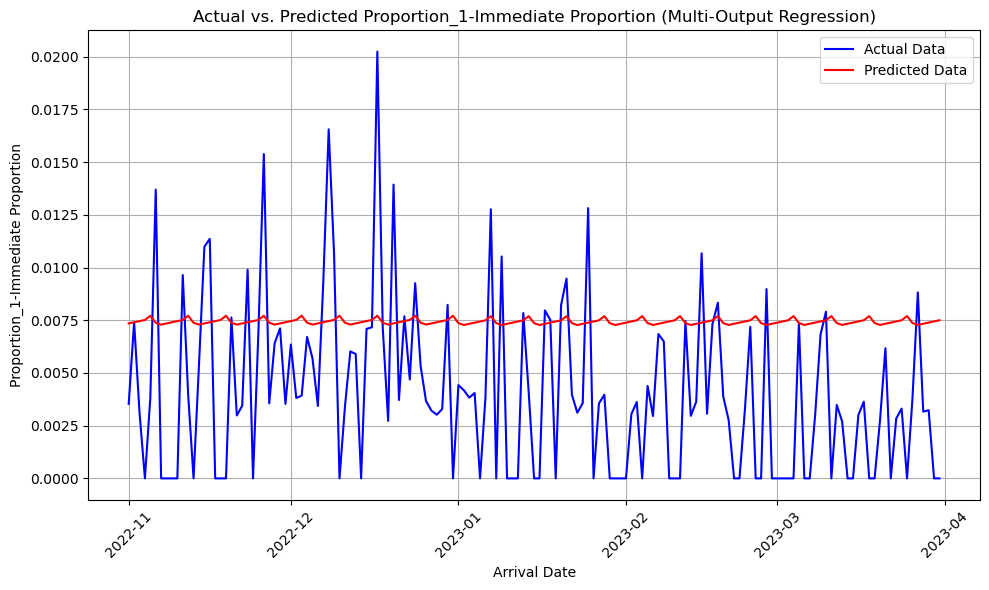

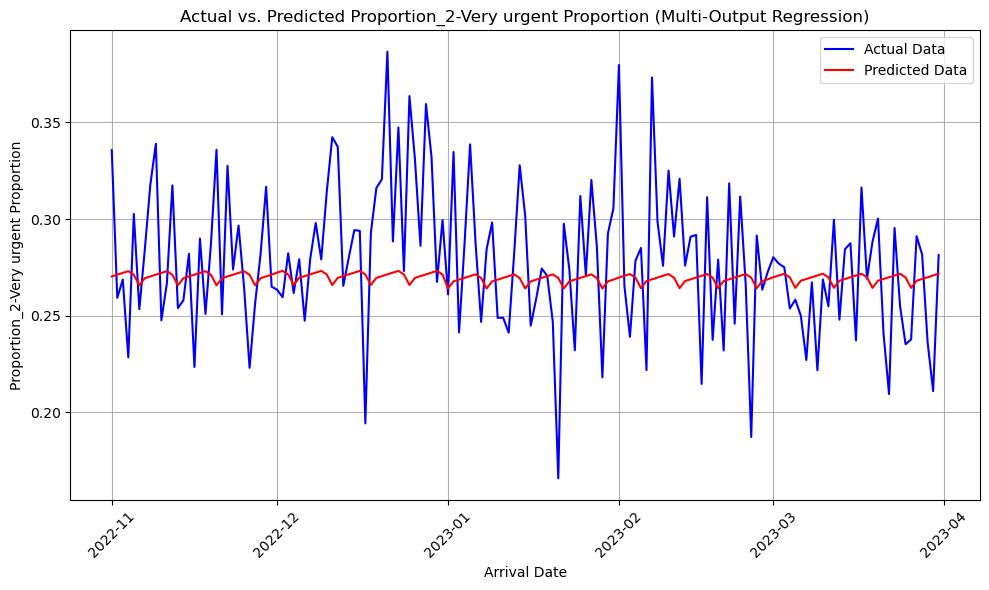

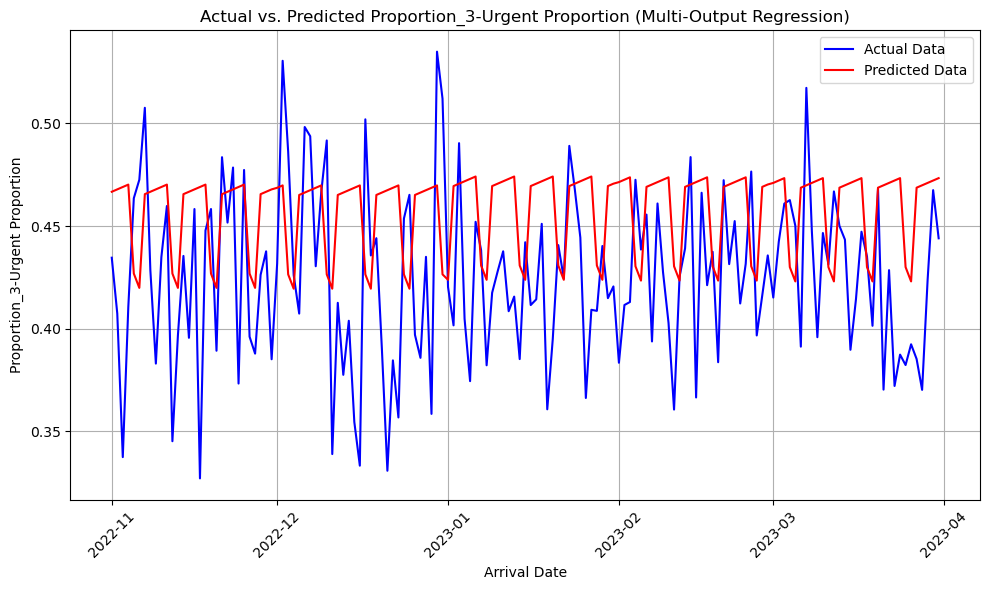

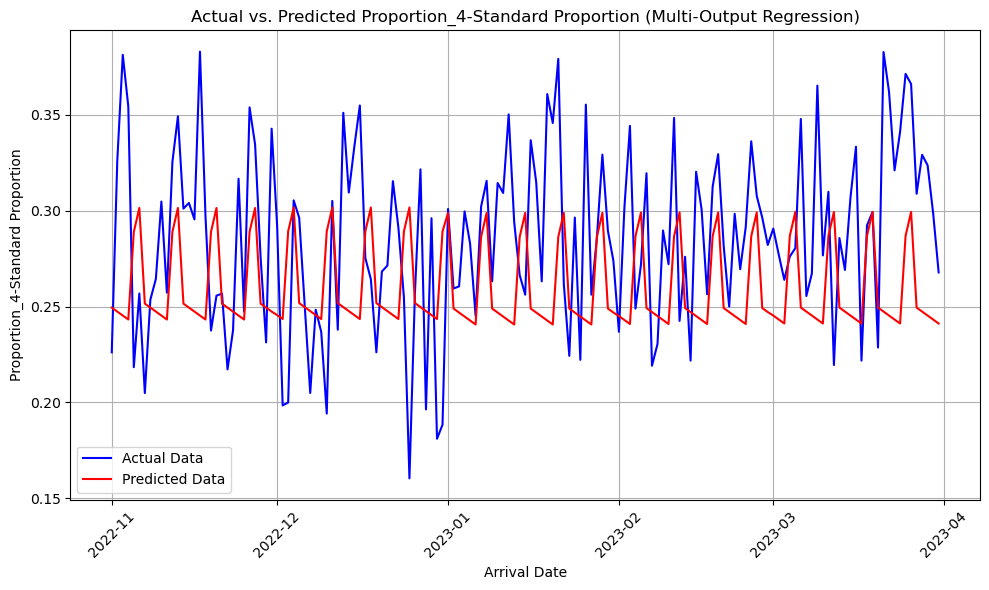

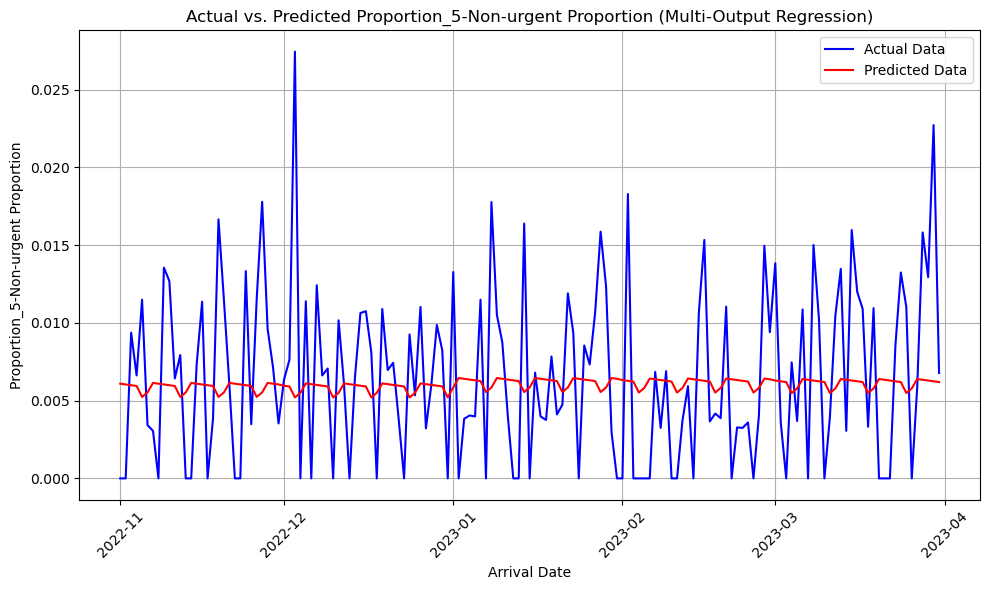

In [89]:
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load your data and set the index if not done already
# sea_df = pd.read_csv('your_data.csv', index_col='Arrival Date')

# Split the data into training and testing sets
train_start = '2009-01-01'
train_end = '2022-10-31'
test_start = '2022-11-01'
test_end = '2023-03-31'

train_data = sea_df[train_start:train_end]
test_data = sea_df[test_start:test_end]

# Extract features and target variables
features = ["COVID_Status_Encoded", "Month_Encoded", "Day_of_Week_Encoded", "Season_Num", "Is_Weekend_Encoded"]
triage_proportions = ['Proportion_1-Immediate', 'Proportion_2-Very urgent', 'Proportion_3-Urgent',
                      'Proportion_4-Standard', 'Proportion_5-Non-urgent']

X_train = train_data[features]
y_train = train_data[triage_proportions]
X_test = test_data[features]
y_test = test_data[triage_proportions]

# Create a Multi-Output Regression model with Linear Regression as the base estimator
model = MultiOutputRegressor(LinearRegression())
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Create a DataFrame for predictions with the Arrival Date as the index
prediction_dates = pd.date_range(start=test_start, end=test_end)
predictions_df = pd.DataFrame({'Arrival Date': prediction_dates})
for i, triage_label in enumerate(triage_proportions):
    predictions_df[f'Predicted_{triage_label}'] = predictions[:, i]
predictions_df.set_index('Arrival Date', inplace=True)

# Calculate metrics for each triage proportion
metrics = {}
for i, triage_label in enumerate(triage_proportions):
    mse = mean_squared_error(y_test[triage_label], predictions_df[f'Predicted_{triage_label}'])
    mae = mean_absolute_error(y_test[triage_label], predictions_df[f'Predicted_{triage_label}'])
    r2 = r2_score(y_test[triage_label], predictions_df[f'Predicted_{triage_label}'])

    metrics[triage_label] = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

# Print metrics for each triage proportion
for triage_label, metric_values in metrics.items():
    print(f"Metrics for {triage_label}:")
    print("Mean Squared Error (MSE):", metric_values['MSE'])
    print("Mean Absolute Error (MAE):", metric_values['MAE'])
    print("R-squared (R2):", metric_values['R2'])
    print()

# Visualize the results for each triage proportion
for triage_label in triage_proportions:
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.index, y_test[triage_label], label='Actual Data', color='blue')
    plt.plot(predictions_df.index, predictions_df[f'Predicted_{triage_label}'],
             label='Predicted Data', color='red')
    plt.xlabel('Arrival Date')
    plt.ylabel(f'{triage_label} Proportion')
    plt.title(f'Actual vs. Predicted {triage_label} Proportion (Multi-Output Regression)')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

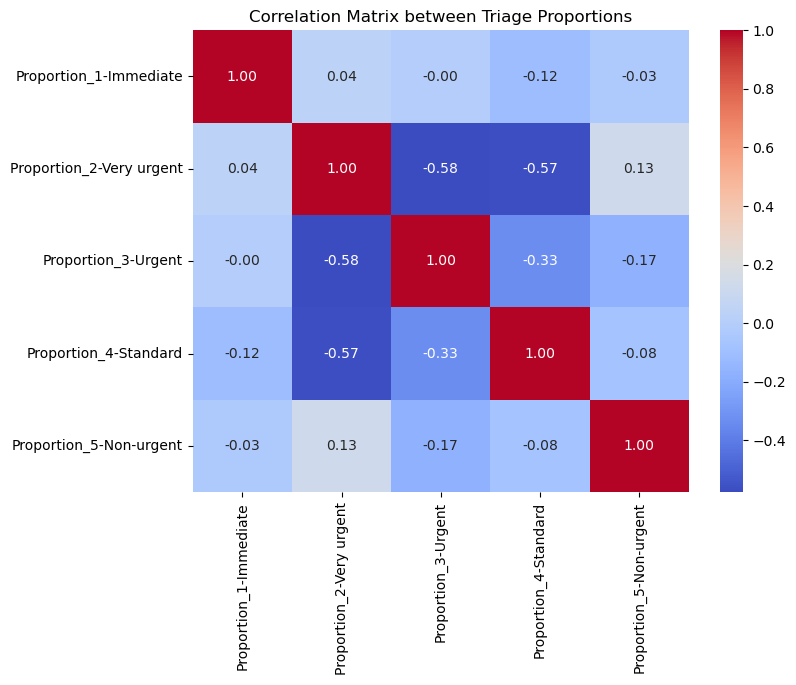

In [90]:
# Calculate the correlation matrix
triage_correlation_matrix = sea_df[triage_proportions].corr()

# Display the correlation matrix as a heatmap
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(triage_correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix between Triage Proportions")
plt.show()